In [55]:
import numpy as np # fundamental package for scientific computing in Python.
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # data visualization library

In [56]:
# Read in CSV data to Dataframe
df = pd.read_csv('ADM.csv')
saved_df = df.copy(deep = True) # create copy of orginal dataframe

# Drop Multiple Columns (not required for this analysis)
df = df.drop(['Open','High','Low','Volume','Adj Close'], axis=1)

# subset of data
df = df.iloc[9200:9850]
df.reset_index(inplace=True) # Reset the index to default integer index

#
df

,index,Date,Close
0,9200,2016-09-07,44.020000
1,9201,2016-09-08,43.240002
2,9202,2016-09-09,42.020000
3,9203,2016-09-12,42.959999
4,9204,2016-09-13,42.000000
...,...,...,...
645,9845,2019-04-02,42.259998
646,9846,2019-04-03,42.220001
647,9847,2019-04-04,42.730000
648,9848,2019-04-05,42.930000


# FEATURE ENGINEERING


In [57]:
# Price Change + Direction
df['closing_price_change'] = df['Close'].diff() # difference between the values in current row and previous row
df['pct_change'] = df['Close'].pct_change()
vals = [] # empty list
for value in df['closing_price_change']:
    if (value >= 0):
        vals.append(1)
    else:
        vals.append(0)           
df['price_change_direction'] = vals # Postive v Negative (Trend Direction)


# Moving Averages
df['SMA'] = df.Close.rolling(window=10).mean() # SMA -->> simple moving average (SMA)
df['CMA'] = df.iloc[:,2].expanding(min_periods=10).mean() # -->> cumaltive moving average (CMA)
df['50ema'] = df.iloc[:,2].ewm(span=50,adjust=False).mean() # -->> exponential moving average (50 day EMA) (weight on recent prices)
df['200ema'] = df.iloc[:,2].ewm(span=200,adjust=False).mean() # -->> exponential moving average (200 day EMA) (weight on recent prices)


# Moving Average Convergence Divergence (MACD)
df['short_ema'] = df.Close.ewm(span=12,adjust=False).mean() # -->> short EMA
df['long_ema'] = df.Close.ewm(span=26,adjust=False).mean() # -->> short EMA
df['macd'] = df.short_ema - df.long_ema # -->> macd line
df['signal'] = df.macd.ewm(span=9,adjust=False).mean() # -->> signal
df['macd_difference_signal'] = df.macd - df.signal
mds = [] # empty list
for value in df['macd_difference_signal']:
    if (value >= 0):
        mds.append("positive")
    else:
        mds.append("negative")           
df['mds_direction'] = mds # Postive v Negative (Trend Direction)


# Relative Strenght Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta>0,0)).rolling(window=14).mean() # average gains (MAs)
loss = (-delta.where(delta<0,0)).rolling(window=14).mean() # average losses (MAs)
rs = gain/loss # RS = avg_gains/avg_losses
rsi = 100 - (100/(1+rs))
df['RSI'] = rsi # rsi value
df['rsi_change'] = df.RSI.diff() # rsi_change()
#
#  RSI direction change
rsi_c = [] # empty list
for val in df['rsi_change']:
    if (val>= 0):
        rsi_c.append(1)
    else:
        rsi_c.append(0)           
df['rsi_change_direction'] = rsi_c # Postive v Negative (Trend Direction)
#
# RSI overbought v oversold flag
indicator = []
for i in range(len(df)):
    if df['RSI'][i] > 70:
        indicator.append("RSI_overbought_indicator")
    elif df['RSI'][i] < 30:
        indicator.append("RSI_oversold_indicator")
    else:
       indicator.append(np.nan)
df['rsi_indicator'] = indicator


# Bollingor Bands (SMA, UpperBand + LowerBand)
df['bollingor_band_sma'] = df['Close'].rolling(window=20).mean() # Calculate the 20-period Simple Moving Average (SMA)
df['bb_sma_std'] = df['Close'].rolling(window=20).std() # Calculate the 20-period Standard Deviation (SD)
df['bb_upper_band'] = df['bollingor_band_sma'] + 2 * df['bb_sma_std'] # Calculate the Upper Bollinger Band (UB) x2 std above
df['bb_lower_band'] = df['bollingor_band_sma'] - 2 * df['bb_sma_std'] # Calculate the Lower Bollinger Band (LB) x2 std below

df

,index,Date,Close,closing_price_change,pct_change,price_change_direction,SMA,CMA,50ema,200ema,...,macd_difference_signal,mds_direction,RSI,rsi_change,rsi_change_direction,rsi_indicator,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band
0,9200,2016-09-07,44.020000,NaN,NaN,0,NaN,NaN,44.020000,44.020000,...,0.000000,positive,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,9201,2016-09-08,43.240002,-0.779999,-0.017719,0,NaN,NaN,43.989412,44.012239,...,-0.049778,negative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,9202,2016-09-09,42.020000,-1.220001,-0.028215,0,NaN,NaN,43.912180,43.992416,...,-0.156112,negative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,9203,2016-09-12,42.959999,0.939999,0.022370,1,NaN,NaN,43.874840,43.982143,...,-0.154119,negative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,9204,2016-09-13,42.000000,-0.959999,-0.022346,0,NaN,NaN,43.801317,43.962420,...,-0.205235,negative,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,9845,2019-04-02,42.259998,-0.420002,-0.009841,0,42.572,44.028251,42.853534,44.547388,...,-0.011085,negative,40.039426,-7.665169,0,NaN,42.6490,0.414283,43.477567,41.820433
646,9846,2019-04-03,42.220001,-0.039997,-0.000946,0,42.564,44.025456,42.828690,44.524230,...,-0.033284,negative,38.767420,-1.272006,0,NaN,42.6535,0.408802,43.471103,41.835896
647,9847,2019-04-04,42.730000,0.509998,0.012080,1,42.549,44.023457,42.824820,44.506377,...,-0.012795,negative,45.810048,7.042628,1,NaN,42.6815,0.392808,43.467115,41.895885
648,9848,2019-04-05,42.930000,0.200001,0.004681,1,42.580,44.021772,42.828944,44.490692,...,0.013623,positive,54.620132,8.810084,1,NaN,42.7320,0.352623,43.437246,42.026753


# DATA VISUALIZATIONS

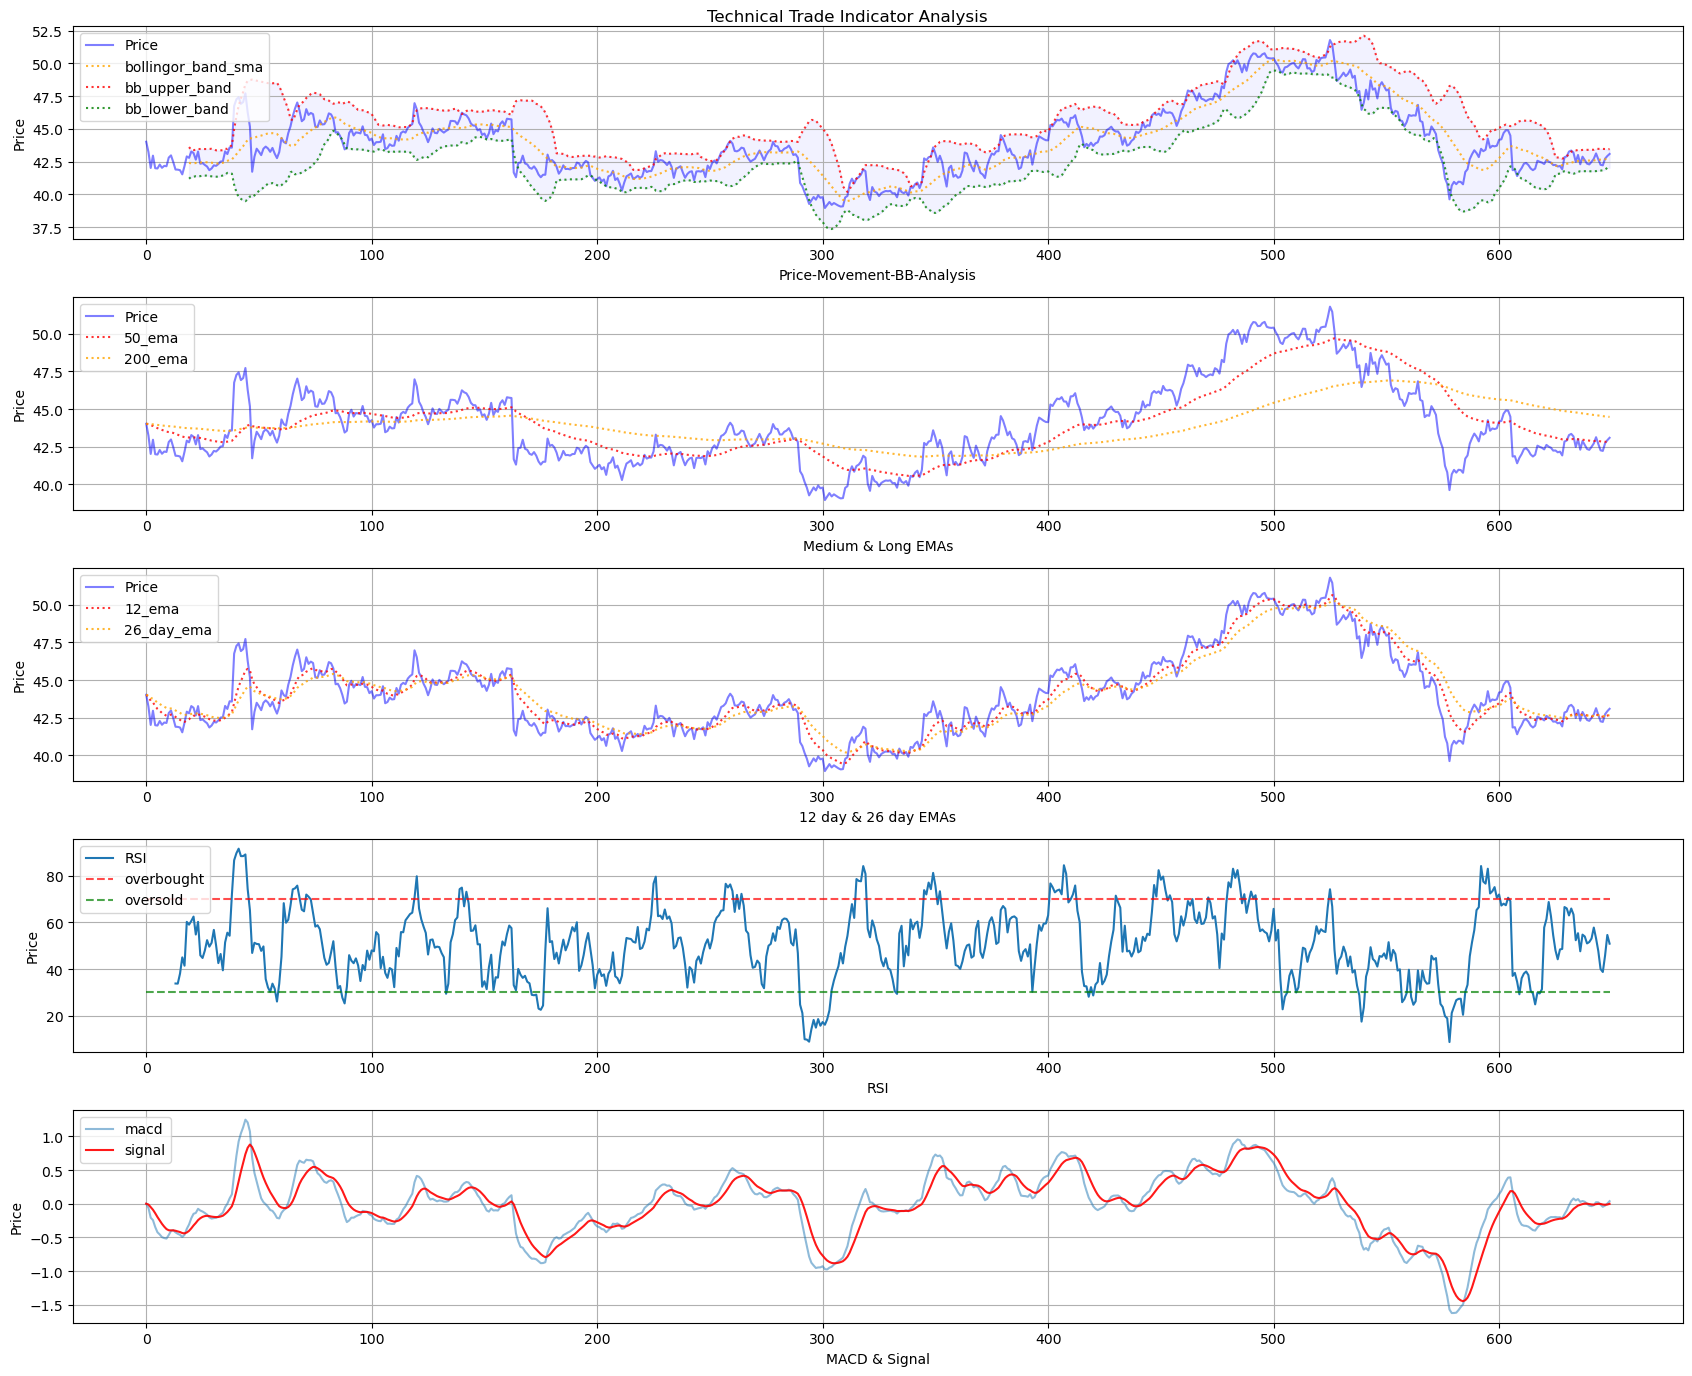

In [60]:
# RSI's
x1,y1 = [0,df.index[-1]],[70,70] # overbought
x2,y2 = [0,df.index[-1]],[30,30] # oversold

# (Subplots) ----- Sharing Y-AXIS
fig, ax = plt.subplots(5, figsize = (17,14), sharey= False)
fig.suptitle('Technical Trade Indicator Analysis', fontsize = 12)
#plt.grid(True)

#
ax[0].plot(df['Close'],color='blue',label='Price',alpha=0.5)
ax[0].plot(df['bollingor_band_sma'],label='bollingor_band_sma',alpha=0.8,linestyle=':',color='orange')
ax[0].plot(df['bb_upper_band'],label='bb_upper_band',alpha=0.8,linestyle=':',color='red')
ax[0].plot(df['bb_lower_band'],label='bb_lower_band',alpha=0.8,linestyle=':',color='green')
ax[0].fill_between(x=df.index, y1=df['bb_upper_band'], y2=df['bb_lower_band'], color='blue', alpha=0.05)

# LONG MA's
ax[1].plot(df['Close'],color='blue',label='Price',alpha=0.5)
ax[1].plot(df['50ema'],label='50_ema',alpha=0.8,linestyle=':',color='red')
ax[1].plot(df['200ema'],label='200_ema',alpha=0.8,linestyle=':',color='orange')

# LONG MA's
ax[2].plot(df['Close'],color='blue',label='Price',alpha=0.5)
ax[2].plot(df['short_ema'],label='12_ema',alpha=0.8,linestyle=':',color='red')
ax[2].plot(df['long_ema'],label='26_day_ema',alpha=0.8,linestyle=':',color='orange')

#
ax[3].plot(df['RSI'],label='RSI')
ax[3].plot(x1, y1,label='overbought',color='red',alpha=0.7,linestyle='--')
ax[3].plot(x2, y2,label='oversold',color='green',alpha=0.7,linestyle='--')

#
ax[4].plot(df['macd'],label='macd',alpha=0.5)
ax[4].plot(df['signal'],label='signal',color='red',alpha=0.9)

# set x & y labels
ax[0].set_xlabel('Price-Movement-BB-Analysis')
ax[1].set_xlabel('Medium & Long EMAs')
ax[2].set_xlabel('12 day & 26 day EMAs')
ax[3].set_xlabel('RSI')
ax[4].set_xlabel('MACD & Signal')
ax[0].set_ylabel('Price')
ax[1].set_ylabel('Price')
ax[2].set_ylabel('Price')
ax[3].set_ylabel('Price')
ax[4].set_ylabel('Price')

#
ax[0].legend(loc=2) 
ax[1].legend(loc=2) 
ax[2].legend(loc=2)
ax[3].legend(loc=2) 
ax[4].legend(loc=2) 

# Iterate through all axes and enable grid
for i in ax.flat:
    i.grid(True)

fig.tight_layout()
plt.show()

RSI_overbought_indicator    79
RSI_oversold_indicator      55
Name: rsi_indicator, dtype: int64


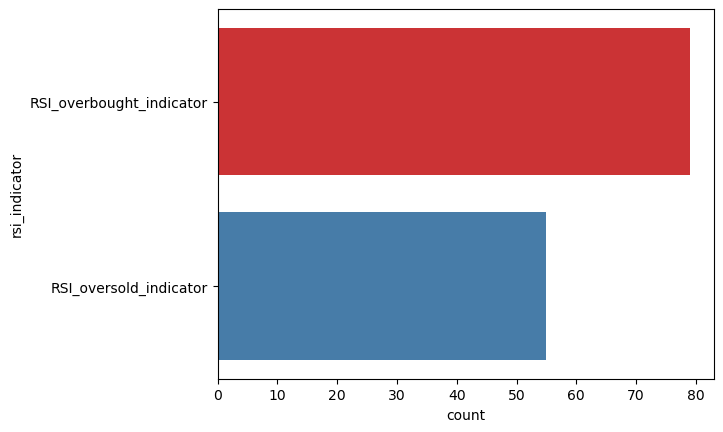

In [59]:
# count plot along y axis
sns.countplot(y ='rsi_indicator', palette = "Set1", data = df)
print(df['rsi_indicator'].value_counts())